<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment_8/XAI_in_LLM_Assignment_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #08



## Akalpit Dawkhar

### **XAI in LLMs**

### Overview

In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques/Assignment_8" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
# !pip install -q -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "/content/Explainable-techniques/Assignment_8"
%ls

Cloning into 'Explainable-techniques'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 259 (delta 30), reused 24 (delta 9), pack-reused 199 (from 1)
Receiving objects: 100% (259/259), 8.12 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/Explainable-techniques/Assignment_8
requirements.txt  XAI_in_LLM_Assignment_08.ipynb


In [1]:
# Install necessary libraries
!pip install -q sentence-transformers umap-learn gensim

# Restart the runtime after installation if necessary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.1 MB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Load the dataset
from sklearn.datasets import fetch_20newsgroups

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

print(f"Number of samples: {len(texts)}")
print(f"Number of categories: {len(set(labels))}")


Number of samples: 11314
Number of categories: 20


In [13]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [12]:
# Load the embedding model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)


In [6]:
# Limit the number of samples for computational efficiency
num_samples = 2000
texts_sampled = texts[:num_samples]
labels_sampled = labels[:num_samples]

# Generate embeddings
embeddings = model.encode(texts_sampled, show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Embedding shape: (2000, 384)


In [7]:
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hls", len(set(labels)))
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, legend='full', palette=palette, s=30)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend([],[], frameon=False)
    plt.show()


PCA reduced shape: (2000, 2)


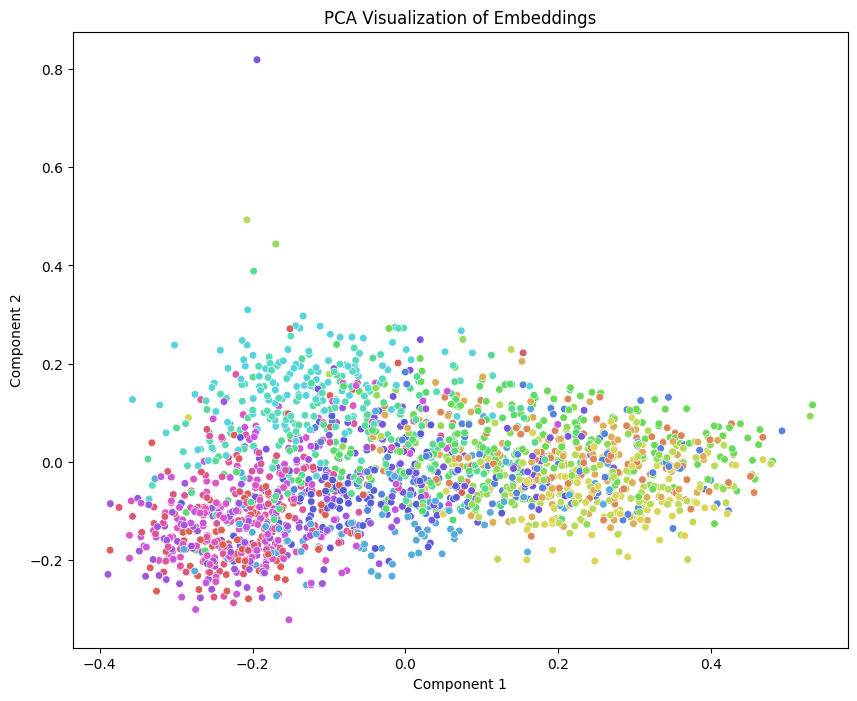

In [8]:
# Apply PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA reduced shape: {embeddings_pca.shape}")

plot_embeddings(embeddings_pca, labels_sampled, 'PCA Visualization of Embeddings')



t-SNE reduced shape: (2000, 2)


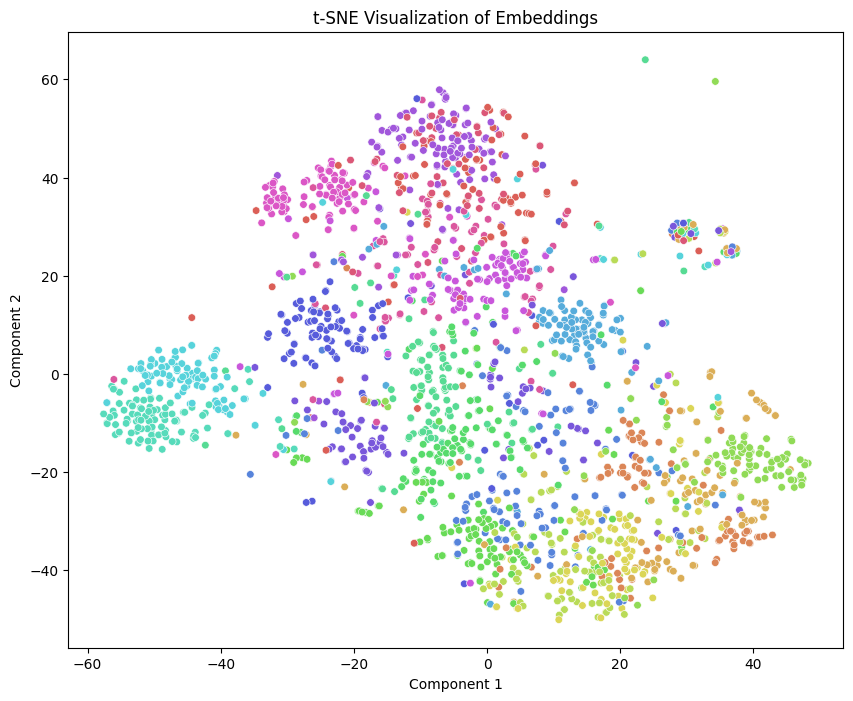

In [9]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
print(f"t-SNE reduced shape: {embeddings_tsne.shape}")

plot_embeddings(embeddings_tsne, labels_sampled, 't-SNE Visualization of Embeddings')


UMAP reduced shape: (2000, 2)


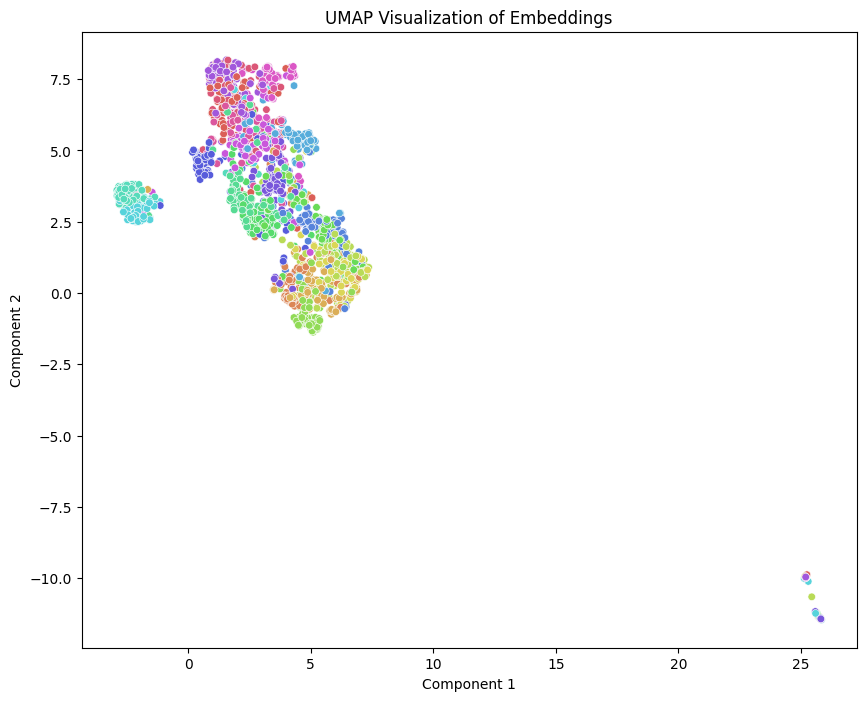

In [10]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)
print(f"UMAP reduced shape: {embeddings_umap.shape}")

plot_embeddings(embeddings_umap, labels_sampled, 'UMAP Visualization of Embeddings')

